In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import os
from pathlib import Path

from astropy.coordinates import SkyCoord, Angle

from gammapy.data import ObservationFilter, DataStore, DataStoreObservation
from gammapy.irf import EffectiveAreaTable2D, EnergyDispersion2D, EnergyDependentMultiGaussPSF, Background3D
from gammapy.spectrum.models import PowerLaw, PowerLaw2
from gammapy.image.models import SkyPointSource
from gammapy.cube import MapEvaluator, PSFKernel, MapMaker, MapMakerObs, MapDataset
from gammapy.utils.fitting import Fit
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap, Map
from gammapy.cube.models import SkyModel, SkyModels, BackgroundModel
from gammapy.cube.exposure import _map_spectrum_weight
from astropy.time import Time
from regions import CircleSkyRegion
from gammapy.irf import make_mean_psf


In [2]:
import gammapy.time

In [3]:
LightCurve = gammapy.time.LightCurve

In [4]:
LightCurveEstimator = gammapy.time.LightCurveEstimator

In [5]:
#Get DR1 data

path = (
    Path(os.environ["GAMMAPY_DATA"])
    / "hess-dl3-dr1/hess-dl3-dr3-with-background.fits.gz"
)
datastore = DataStore.from_file(path)
src=SkyCoord.from_name("PKS 2155-304")
sep=SkyCoord.separation(src,datastore.obs_table.pointing_radec)
Radius=2.3
srcruns=(datastore.obs_table[sep<Radius*u.deg])
myid=srcruns['OBS_ID'].data
mylist=datastore.get_observations(myid)

In [6]:
# Define geoms
emin, emax = [1, 10] * u.TeV
energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 1, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=src,
    binsz=0.05,
    width=(2, 2),
    coordsys="CEL",
    proj="CAR",
    axes=[energy_axis],
)

In [7]:
# Define the source model - Use a pointsource + integrated power law model to directly get flux

spatial_model = SkyPointSource(lon_0=src.ra, lat_0=src.dec, frame="icrs")
spectral_model = PowerLaw2(
    emin=emin, emax=emax, index=2.0, amplitude="3e-10 cm-2 s-1"
)
sky_model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)
sky_model.parameters["index"].frozen = True
sky_model.parameters["lon_0"].frozen = True
sky_model.parameters["lat_0"].frozen = True
sky_model.parameters["amplitude"].min = 0.0

In [8]:
region = CircleSkyRegion(center=src, radius=0.6 * u.deg)

In [9]:
# psf_kernel and MapMaker for each segment
def make_maps(observations):
    maker = MapMaker(geom, offset_max=2.0 * u.deg)
    spectrum = PowerLaw2(index=2)
    maps2D = maker.run_images(observations, spectrum=spectrum, keepdims=True)
    geom2d = maps2D["exposure"].geom
    
    table_psf = make_mean_psf(observations,src)

    table_psf_2d = table_psf.table_psf_in_energy_band(
    (emin, emax), spectrum=spectrum)

    # PSF kernel used for the model convolution
    psf_kernel = PSFKernel.from_table_psf(
        table_psf_2d, geom2d, max_radius="0.3 deg"
        )
    
    return maps2D, psf_kernel

In [10]:
time_start = Time("2006-07-29 20:00:00.000")
time_stop = Time("2006-07-30 06:00:00.00")
time_step = 30.0 * u.min
time_0 = time_start

In [11]:
%%time

map_segments = []
psf_segments = []

mjd = []
while time_start<time_stop:
    
    # get smaller observation lists
    t2 = time_start+time_step
    time_interval = Time([time_start.value, t2.value])
    obs = mylist.select_time(time_interval)
    
    
    #Proceed with further analysis only if there are observations in the selected time window
    if len(obs) > 0: 
        
        maps, psf = make_maps(obs)
        maps['counts'].meta['t_start'] = time_start
        maps['counts'].meta['t_stop'] = t2
        map_segments.append(maps)
        psf_segments.append(psf)
        
        mjd.append((time_start+time_step/2.0).mjd)
    time_start = t2

CPU times: user 27 s, sys: 676 ms, total: 27.7 s
Wall time: 27.8 s


In [12]:
datasets = []
for amap,psf in zip(map_segments,psf_segments):
    #Copy the source model
    model = sky_model.copy()
    
    # Make the background model
    background_model = BackgroundModel(amap["background"])
    background_model.parameters["norm"].frozen = True
    background_model.parameters["tilt"].frozen = True
          
    #Now fit
    dataset = MapDataset(
        model=model,
        counts=amap["counts"],
        exposure=amap["exposure"],
        background_model=background_model,
        psf=psf,
    )
    datasets.append(dataset)

In [13]:
lc = LightCurveEstimator(datasets)

In [14]:
len(datasets)

17

In [15]:
lightcurve = lc.get_lc()

In [16]:
lightcurve.fvar('amplitude')

(0.6960784661004552, 0.024363822778469504)

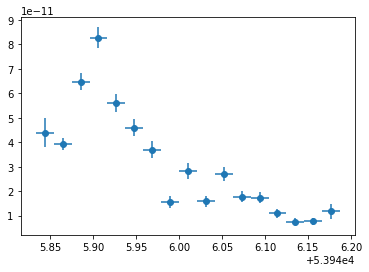

In [17]:
lightcurve.plot('amplitude')

In [18]:
lightcurve.chisq('amplitude')

(2.463538105118879e-10, 1.0)

In [19]:
lightcurve.table['amplitude_likelihood_profile']

"{'amplitude_scan': array([8.48372901e-12, 1.08432550e-11, 1.32027810e-11, 1.55623070e-11, 1.79218330e-11, 2.02813590e-11, 2.26408850e-11, 2.50004110e-11, 2.73599369e-11, 2.97194629e-11, 3.20789889e-11, 3.44385149e-11, 3.67980409e-11, 3.91575669e-11, 4.15170929e-11, 4.38766189e-11, 4.62361449e-11, 4.85956709e-11, 5.09551969e-11, 5.33147229e-11, 5.56742489e-11, 5.80337748e-11, 6.03933008e-11, 6.27528268e-11, 6.51123528e-11, 6.74718788e-11, 6.98314048e-11, 7.21909308e-11, 7.45504568e-11, 7.69099828e-11, 7.92695088e-11]), 'dloglike_scan': array([1989.93872349, 1971.02695093, 1956.54179706, 1945.13930997, 1936.01111787, 1928.63191532, 1922.64056822, 1917.77789571, 1913.85146644, 1910.71440979, 1908.25204569, 1906.37309021, 1905.0036776 , 1904.08318652, 1903.56124176, 1903.39552301, 1903.55013307, 1903.99435352, 1904.70169779, 1905.64916221, 1906.81664168, 1908.18645926, 1909.74299396, 1911.4723688 , 1913.36220174, 1915.40139978, 1917.57998138, 1919.88893964, 1922.32011117, 1924.86607726, 1927.52007969])}"
"{'amplitude_scan': array([2.39878430e-11, 2.50017970e-11, 2.60157510e-11, 2.70297051e-11, 2.80436591e-11, 2.90576131e-11, 3.00715671e-11, 3.10855211e-11, 3.20994752e-11, 3.31134292e-11, 3.41273832e-11, 3.51413372e-11, 3.61552913e-11, 3.71692453e-11, 3.81831993e-11, 3.91971533e-11, 4.02111073e-11, 4.12250614e-11, 4.22390154e-11, 4.32529694e-11, 4.42669234e-11, 4.52808775e-11, 4.62948315e-11, 4.73087855e-11, 4.83227395e-11, 4.93366936e-11, 5.03506476e-11, 5.13646016e-11, 5.23785556e-11, 5.33925096e-11, 5.44064637e-11]), 'dloglike_scan': array([3851.58566646, 3844.38612497, 3837.93004223, 3832.16432645, 3827.04143091, 3822.51861313, 3818.55729838, 3815.12255768, 3812.18265059, 3809.70865425, 3807.67413707, 3806.05486724, 3804.82859256, 3803.97481169, 3803.47460301, 3803.31046625, 3803.46618155, 3803.92667921, 3804.67794483, 3805.70691769, 3807.00139683, 3808.54998611, 3810.34200334, 3812.36744039, 3814.61688825, 3817.08151032, 3819.752981 , 3822.62345437, 3825.68552291, 3828.93218914, 3832.35684427])}"
"{'amplitude_scan': array([4.39284363e-11, 4.53146872e-11, 4.67009380e-11, 4.80871888e-11, 4.94734397e-11, 5.08596905e-11, 5.22459413e-11, 5.36321921e-11, 5.50184430e-11, 5.64046938e-11, 5.77909446e-11, 5.91771955e-11, 6.05634463e-11, 6.19496971e-11, 6.33359480e-11, 6.47221988e-11, 6.61084496e-11, 6.74947005e-11, 6.88809513e-11, 7.02672021e-11, 7.16534530e-11, 7.30397038e-11, 7.44259546e-11, 7.58122054e-11, 7.71984563e-11, 7.85847071e-11, 7.99709579e-11, 8.13572088e-11, 8.27434596e-11, 8.41297104e-11, 8.55159613e-11]), 'dloglike_scan': array([1690.71763743, 1684.09781903, 1678.11185577, 1672.72418026, 1667.90214915, 1663.61573381, 1659.83726994, 1656.54117422, 1653.70377994, 1651.30311906, 1649.31878062, 1647.73175474, 1646.52431766, 1645.67991449, 1645.18304876, 1645.01920668, 1645.17477392, 1645.63694335, 1646.39368811, 1647.43365934, 1648.74617425, 1650.32112851, 1652.14898664, 1654.22071199, 1656.52775995, 1659.06202237, 1661.81581144, 1664.7818093 , 1667.95307719, 1671.32300231, 1674.88529635])}"
"{'amplitude_scan': array([5.76169834e-11, 5.92965169e-11, 6.09760504e-11, 6.26555839e-11, 6.43351174e-11, 6.60146509e-11, 6.76941843e-11, 6.93737178e-11, 7.10532513e-11, 7.27327848e-11, 7.44123183e-11, 7.60918518e-11, 7.77713853e-11, 7.94509188e-11, 8.11304522e-11, 8.28099857e-11, 8.44895192e-11, 8.61690527e-11, 8.78485862e-11, 8.95281197e-11, 9.12076532e-11, 9.28871867e-11, 9.45667201e-11, 9.62462536e-11, 9.79257871e-11, 9.96053206e-11, 1.01284854e-10, 1.02964388e-10, 1.04643921e-10, 1.06323455e-10, 1.08002988e-10]), 'dloglike_scan': array([952.45678727, 945.92112171, 939.99901516, 934.65844491, 929.869845 , 925.60586867, 921.84115057, 918.55214624, 915.71694121, 913.31510182, 911.32756342, 909.73648969, 908.52518391, 907.67798369, 907.18017856, 907.01793917, 907.17824766, 907.64882406, 908.41809285, 909.47510444, 910.80951153, 912.41150929, 914.27181488, 916.38161545, 918.73254812, 921.31666217, 924.12639935, 927.15454622, 930.394267

In [29]:
ul = []
for arow in lightcurve.table:
    l_profile = arow['amplitude_likelihood_profile']
    if arow['is_ul']:
        lim = sigma_limit * 0.5 + np.min(l_profile['dloglike_scan'])
        arr = np.where(l_profile['dloglike_scan'] < lim)
        func = interp1d(l_profile['dloglike_scan'][arr[-1], arr[-1]+1],
                    l_profile["amplitude_scan"][arr[-1], arr[-1]+1])
        ul.append(func(lim))
    else:
        ul.append(np.nan)
lightcurve.table["upper_limits"]=ul

In [31]:
lightcurve.table.colnames

['time_bin_start',
 'time_bin_end',
 'amplitude',
 'amplitude_err',
 'amplitude_likelihood_profile',
 'TS',
 'is_ul',
 'upper_limits']

In [20]:
lightcurve.compute_ul()

KeyError: 'likelihood_profile'

In [ ]:
y_unit = self.table['amplitude'].unit


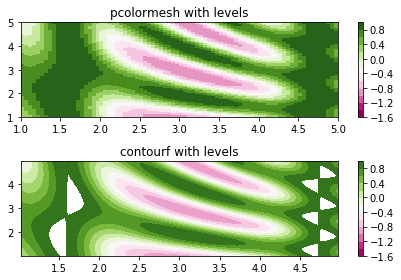

In [44]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np


# make these smaller to increase the resolution
dx, dy = 0.05, 0.05

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(1, 5 + dy, dy),
                slice(1, 5 + dx, dx)]

z = np.sin(x)**10 + np.cos(10 + y*x) * np.cos(x)

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
levels = MaxNLocator(nbins=15).tick_values(-1.5,1.0)


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0, ax1) = plt.subplots(nrows=2)

im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('pcolormesh with levels')


# contours are *point* based plots, so convert our bound into point
# centers
cf = ax1.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., z, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title('contourf with levels')

# adjust spacing between subplots so `ax1` title and `ax0` tick labels
# don't overlap
fig.tight_layout()

plt.show()

In [29]:
y

array([[1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
       [1.05, 1.05, 1.05, ..., 1.05, 1.05, 1.05],
       [1.1 , 1.1 , 1.1 , ..., 1.1 , 1.1 , 1.1 ],
       ...,
       [4.9 , 4.9 , 4.9 , ..., 4.9 , 4.9 , 4.9 ],
       [4.95, 4.95, 4.95, ..., 4.95, 4.95, 4.95],
       [5.  , 5.  , 5.  , ..., 5.  , 5.  , 5.  ]])

In [30]:
x

array([[1.  , 1.05, 1.1 , ..., 4.9 , 4.95, 5.  ],
       [1.  , 1.05, 1.1 , ..., 4.9 , 4.95, 5.  ],
       [1.  , 1.05, 1.1 , ..., 4.9 , 4.95, 5.  ],
       ...,
       [1.  , 1.05, 1.1 , ..., 4.9 , 4.95, 5.  ],
       [1.  , 1.05, 1.1 , ..., 4.9 , 4.95, 5.  ],
       [1.  , 1.05, 1.1 , ..., 4.9 , 4.95, 5.  ]])

In [31]:
np.mgrid?

In [32]:
z

array([[ 0.18037951,  0.26823017,  0.36335424, ...,  0.81967616,
         0.70887839,  0.58107739],
       [ 0.20738012,  0.2942647 ,  0.38808212, ...,  0.79738125,
         0.68002396,  0.54664565],
       [ 0.23430727,  0.3201529 ,  0.41259223, ...,  0.78164078,
         0.66058997,  0.5247303 ],
       ...,
       [-0.17535841, -0.1651069 , -0.10633898, ...,  0.83935699,
         0.70681157,  0.55135416],
       [-0.19534556, -0.17962168, -0.11478605, ...,  0.81308152,
         0.67850552,  0.52732772],
       [-0.21439958, -0.19297694, -0.12193009, ...,  0.79244172,
         0.65971059,  0.51699498]])

In [33]:
np.shape(z)

(80, 80)

In [35]:
np.shape(y)

(81, 81)

In [40]:
z.min(), z.max()

(-0.9998834929834033, 1.0507695110008357)